Goal:
- Take single input image
- Embed image
- Feed embed to distance model   
    a. if new image: returns x similar and adds image to directory  
    b. if image exists: returns existing photo
- Return a or b

Next steps:
- Can I return suggestions based on central vertices?
- Turning it into a demo
- Clean up notebooks/github
- Presentation
- More images (only if i can time the clustering to go overnight)

## Set Up

In [1]:
import os
import sys
#set custom path
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\anaconda\envs\tf_keras_gpu_test\lib\site-packages'))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333) 
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from torchvision import datasets, transforms
import torch

from copy import deepcopy as dc
import random
from statistics import mean


from PIL import Image
import requests
from io import BytesIO

%run data_functions.py

## 1. Import existing

In [3]:
#code to try clustering subset of embeddings

#import embeddings of existing dir
#all_embeds = np.load('../features.npy')
#np.save('../image_dir/features.npy', all_embeds[:1000])

In [4]:
#pull in base embeds
base_embeds  = np.load('../image_dir/features.npy')


#load base images
data_dir = '../image_dir/samples'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

image_datasets = datasets.ImageFolder(data_dir, transform = tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)
print(len(image_datasets)) #number of datapoints

6544


In [5]:
file_keys = []

for i, file in enumerate(os.listdir('../image_dir/samples/pics')):
    
    file_name = str(file).replace('.jpeg', '')
    
    temp_key = np.array((i, file_name))
    file_keys.append(temp_key)
    
file_keys_df = pd.DataFrame(file_keys, columns = ['idx', 'file_name']).set_index('idx')

In [6]:
#function to translate input file name to index within dataset
def get_image(file_name):
    return int(file_keys_df.loc[file_keys_df['file_name'] == file_name].index[0])
    
get_image('5')

4445

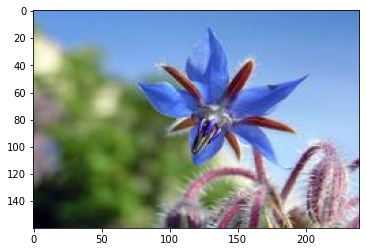

In [7]:
plt.imshow((image_datasets[get_image('5407')][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

## 2. Embed new image

In [8]:
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\Lighthouse_Labs\Final\distribution_clustering'))


%run ..\distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\test_dir

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


In [9]:
#load test image embed
input_embed = np.load('../test_dir/features.npy')
print(input_embed.shape)

(1, 2048)


## 3. Find Duplicate

In [10]:
def get_distance(input_embed, base_embeds = base_embeds):
    import scipy.spatial

    #translate to same size array as base embeds
    input_expanded = np.repeat(input_embed, len(base_embeds), axis = 0)
    
    input_dist = scipy.spatial.distance.cdist(input_expanded, base_embeds, 'sqeuclidean')
    input_dist = input_dist[0]
    return input_dist

def image_duplicate(embed_distances, plot_dup_image = False):
    
    if min(embed_distances) == 0:
        print('Photo Exists')
        dup_idx = np.where(embed_distances == min(embed_distances))[0][0]
        
        if bool(plot_dup_image):
            plt.imshow((image_datasets[dup_idx][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
            
    else:
        print('Photo does not exist yet')
        dup_idx = None
    
    return dup_idx
        

Photo Exists


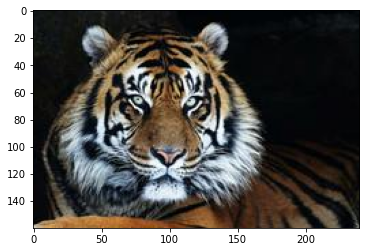

In [11]:
input_dist = get_distance(input_embed)

dup_idx = image_duplicate(input_dist, plot_dup_image = True)

## 4. Recommend

In [12]:
def return_recommendation(input_distances, duplicate_idx, path, plot_similar = False):
    
    cluster_idx = np.load(os.path.join(path, 'cluster_idx.npy'))
    
    #is duplicate
    if duplicate_idx is not None:
        input_cluster = cluster_idx[dup_idx]
        #get file name of dup_idx
        dup_file = int(file_keys_df.iloc[dup_idx][0])
    
    #is not duplicate
    if duplicate_idx is None:
        anchor_idx = input_distances.argsort()[1]
        input_cluster = cluster_idx[anchor_idx]
        dup_file = None
        print(input_cluster)
    #list images from within cluster
    similar_imgs = os.listdir(os.path.join(path, 'clusters', str(input_cluster)))
    
    #turn into int
    similar_idx = []
    for image in similar_imgs:
        temp_idx = int(str(image).replace('.jpeg', ''))
        #if not duplicate file
        if temp_idx != dup_file:
            similar_idx.append(temp_idx)
    
    #if plot is true plot similar images
    if bool(plot_similar):
        fig, axes = plt.subplots(1, 4, figsize = (10, 2))
        
        for i, ax in enumerate(axes.flat):
            ax.imshow((image_datasets[get_image(str(similar_idx[i]))][0].detach().numpy().transpose(1, 2, 0)* 255).astype(np.uint8))


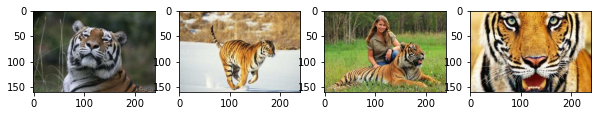

In [13]:
return_recommendation(input_dist, dup_idx, '../image_dir', plot_similar = True)

### Test on original image

In [14]:
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\Lighthouse_Labs\Final\distribution_clustering'))


%run ..\distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\test2_dir

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


In [15]:
unique_embed = np.load('../test2_dir/features.npy')

unique_distances = get_distance(unique_embed)
_ = image_duplicate(unique_distances, plot_dup_image= True)

Photo does not exist yet


859


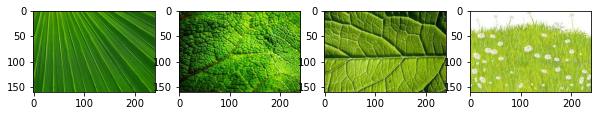

In [16]:
return_recommendation(unique_distances, None, '../image_dir', plot_similar = True)

In [17]:
stop

NameError: name 'stop' is not defined

## 4.5 Sample Testing

In [ ]:
#pull in test embeds
test_embeds  = np.load('../sample_dir/features.npy')


#load test images
test_dir = '../sample_dir/samples'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

test_dataset = datasets.ImageFolder(test_dir, transform = tc)
dloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_dataset)) #number of datapoints

In [ ]:
#get distances between input image and every test image
import scipy.spatial

test_dist = scipy.spatial.distance.cdist(input_expanded, test_embeds, 'sqeuclidean')
test_dist = test_dist[0]

#find duplicate
print(min(pair_dist))
dup_idx = np.where(pair_dist == min(pair_dist))[0][0]
print(dup_idx)

plt.imshow((image_datasets[dup_idx][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

In [ ]:
#closest image that's not a duplicate
print(pair_dist.argsort()[1])

plt.imshow((image_datasets[pair_dist.argsort()[1]][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

In [ ]:
#show cluster of duplicate
cluster_idx = np.load('../sample_dir/cluster_idx.npy')
print(cluster_idx[390])

#cluster of duplicate's closest image
cluster_idx[64]

# Old Script

## Import

In [ ]:
#import embeddings of existing dir
base_embeds = np.load('embeddings.npy')
base_embeds.shape
np.save('features', base_embeds[:500])

In [ ]:
# Select the desired layer, one before it classifies
layer = model._modules.get('avgpool')

#use register_forward_hook module to get embeddings
def copy_embeddings(m, i, o):

    """Copy embeddings from the penultimate layer.

    """

    o = o[:, :, 0, 0].detach().numpy().tolist()

    outputs.append(o)

outputs = []

# attach hook to the penulimate layer
_ = layer.register_forward_hook(copy_embeddings)


In [ ]:
#load base images
from torchvision import datasets, transforms
import torch

data_dir = '../image_dir'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

image_datasets = datasets.ImageFolder(data_dir, transform = tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=14, shuffle=False)
print(len(image_datasets)) #number of datapoints

In [ ]:
#load 'input' image(s)
new_dataset = datasets.ImageFolder('../test_dir', transform = tc)
new_dloader = torch.utils.data.DataLoader(new_dataset, batch_size=1, shuffle=False)
print(len(new_dloader)) #number of datapoints

## Generate new embeds

In [ ]:
random.seed(30)
model.eval() # Inference mode

# Generate image embeddings for all images in dloader and save them in the list outputs
for X, y in new_dloader:
    _ = model(X)

print(len(outputs)) 

# flatten list of embeddings to remove batches
new_embeddings = [item for sublist in outputs for item in sublist]

print(len(new_embeddings)) # should return same length as dloader
print(np.array(new_embeddings[0]).shape) #returns (512,)

In [ ]:
plt.imshow((new_dataset[2][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

In [ ]:
#loop for multiple input images
dup_indicies = []

for i, new_image in enumerate(new_embeddings):
    
    dup_index, exists = does_image_exist(new_image, visual = False)
    dup_indicies.append(dup_index)
        
print(dup_indicies)

## 3. Test is duplicate

In [ ]:
def does_image_exist(test_embed, visual = True, base_embeds = base_embeds, abs_tol = 0.001):
    #single image test
    from math import isclose
    exists = False
    
    for i, base_item in enumerate(base_embeds):
        
        if isclose(sum(base_item - test_embed), 0, abs_tol = abs_tol):
            print('Exists')
            dup_index = i
            exists = True
            if visual is True:
                plt.imshow((image_datasets[get_image(str(i))][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
            
    if exists is False:
        print('Does not Exist')
        dup_index = None
        
    return dup_index, exists

In [ ]:
dup_index, exists = does_image_exist(input_embed[0])
print(dup_index)